# Bayesian Regression
> 
- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/svi.jpg


Consider a binary regression problem where we are intrested on predicting whether or not a customer will subscribe a term deposit after the marketing campaign the bank performed.

In [1]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
import torch.nn.functional as F
from pyro.infer import Trace_ELBO, SVI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def label_binarize(df):
    bin_enc = LabelBinarizer()
    return bin_enc.fit_transform(df)

def standardize(df):
    std_enc = StandardScaler()
    return std_enc.fit_transform(df)

### Load data

In [3]:
data = pd.read_csv("data/bank.csv")

## Encode target variable
LE=LabelEncoder()
target=LE.fit_transform(data.deposit.values)
features = data.drop(columns="deposit")

# Separate both dataframes into 
numeric_data = data.select_dtypes(exclude="object")
categ_data  = data.drop(columns=numeric_data)
#categ_data = pd.get_dummies(categ_data.values)

In [4]:
for column in categ_data.columns:
    categ_data[column] = label_binarize(categ_data[column].values)
    
columns_int = ["campaign", "pdays", "previous"]
for i, column  in enumerate(columns_int):
    numeric_data[column] = label_binarize(numeric_data[column].values)
    
    
numeric_column = ["age", "balance", "day", "duration"]
for i, column  in enumerate(numeric_column):
    numeric_data[column] = standardize(numeric_data[[column]].values)
    


In [5]:
features = pd.concat([numeric_data, categ_data], 1)
features = torch.tensor(features.values).float()
target   = torch.tensor(target).long()

In [6]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
train, test = next(sss.split(features.numpy(), target.numpy()))

In [7]:
X_train, X_test = features[train], features[test]
y_train, y_test = target[train], target[test]

## Model

In [8]:
from pyro.nn import PyroSample
from torch import nn
from pyro.nn import PyroModule
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features=1):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = torch.sigmoid(self.linear(x).squeeze(-1))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(mean), obs=y)
        return mean

### Guide

In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(features.size(-1), 1)
guide = AutoDiagonalNormal(model)


In [10]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [11]:
for j in range(5000):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train, y_train.float())
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(X_train)))

[iteration 0001] loss: 2.5517
[iteration 0101] loss: 0.2323
[iteration 0201] loss: 0.1161
[iteration 0301] loss: 0.0744
[iteration 0401] loss: 0.0537
[iteration 0501] loss: 0.0425
[iteration 0601] loss: 0.0330
[iteration 0701] loss: 0.0286
[iteration 0801] loss: 0.0265
[iteration 0901] loss: 0.0241
[iteration 1001] loss: 0.0206
[iteration 1101] loss: 0.0207
[iteration 1201] loss: 0.0192
[iteration 1301] loss: 0.0185
[iteration 1401] loss: 0.0178
[iteration 1501] loss: 0.0172
[iteration 1601] loss: 0.0162
[iteration 1701] loss: 0.0166
[iteration 1801] loss: 0.0161
[iteration 1901] loss: 0.0152
[iteration 2001] loss: 0.0155
[iteration 2101] loss: 0.0147
[iteration 2201] loss: 0.0150
[iteration 2301] loss: 0.0142
[iteration 2401] loss: 0.0145
[iteration 2501] loss: 0.0143
[iteration 2601] loss: 0.0145
[iteration 2701] loss: 0.0135
[iteration 2801] loss: 0.0136
[iteration 2901] loss: 0.0136
[iteration 3001] loss: 0.0141
[iteration 3101] loss: 0.0129
[iteration 3201] loss: 0.0131
[iteration

In [43]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

w_loc tensor([-0.0071,  0.0229, -0.0480,  0.8757,  0.0749, -0.9454, -0.9454,  0.0240,
        -0.1021, -0.3675, -0.1923, -0.9378, -0.4416, -0.0203,  0.2147, -1.3860,
         6.3369], requires_grad=True)
w_scale tensor([-1.9725, -2.2263, -1.8859, -1.4443, -1.4062, -1.3978, -1.3952, -1.3166,
        -1.2706, -1.2814, -0.7051, -1.3490, -1.2376, -1.4575, -1.2055, -1.3631,
        -0.8033], requires_grad=True)
b_loc tensor(-0.9499, requires_grad=True)
b_scale tensor(-1.4293, requires_grad=True)
sigma_loc tensor(0.4712, requires_grad=True)
sigma_scale tensor(1.0128, requires_grad=True)
AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.0622e-01, -3.7485e-03, -3.0043e-02, -8.0583e-02,  6.4904e-01,
         1.8374e-01, -3.6323e-01, -3.5512e-01, -2.5773e-02,  5.6965e-02,
        -1.7738e-01,  4.0707e-02, -5.3365e-01, -2.6170e-01,  3.2216e-01,
         4.4906e-02, -2.5154e-01,  1.2037e+01, -5.6873e+00])
AutoDiagonalNormal.scale tensor([1.8662, 0.1736, 0.1103, 0.1989, 0.2169, 0.2756, 0.2084

In [12]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(2.6640, grad_fn=<AddBackward0>),
  tensor(5.1130, grad_fn=<AddBackward0>),
  tensor(7.5088, grad_fn=<AddBackward0>)],
 'linear.weight': [tensor([[-0.1639, -0.0724, -0.1268,  0.5418, -0.1031, -0.8266, -0.8063, -0.3514,
           -0.3640, -0.5699, -0.6837, -0.8097, -0.5691, -0.2390, -0.1894, -0.9103,
           11.7423]], grad_fn=<ViewBackward>),
  tensor([[-3.0203e-02,  9.4208e-03, -1.1705e-02,  6.6436e-01,  1.0644e-01,
           -6.6798e-01, -6.3090e-01, -1.4548e-02, -1.4773e-03, -2.6955e-01,
           -1.1549e-01, -6.2662e-01, -2.8048e-01, -8.6887e-02,  1.1106e-01,
           -6.1579e-01,  1.1925e+01]], grad_fn=<ViewBackward>),
  tensor([[ 1.0347e-01,  9.1200e-02,  1.0336e-01,  7.8690e-01,  3.1602e-01,
           -5.0940e-01, -4.5552e-01,  3.2231e-01,  3.6107e-01,  3.0746e-02,
            4.5273e-01, -4.4355e-01,  8.1125e-03,  6.5219e-02,  4.1150e-01,
           -3.2128e-01,  1.2108e+01]], grad_fn=<ViewBackward>)],
 'linear.bias': [tensor([-4.5520], grad_fn=<ViewB

In [15]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(X_test)
pred_summary = summary(samples)

In [17]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]


(array([880.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0., 794.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

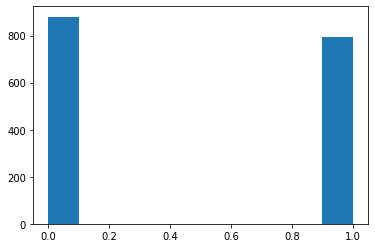

In [20]:
plt.hist(y['mean'])

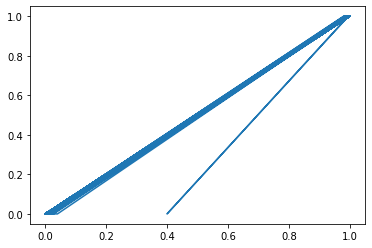

In [58]:
plt.plot(y['mean'], y_test)

In [ ]:
## Reference

1. [[Cheng Zhang,(2017)]](https://arxiv.org/abs/1711.05597):
Advances in Variational Inference.
2. [[Daniel Ritchie,(2016)]](https://arxiv.org/abs/1610.05735):Deep Amortized Inference for Probabilistic Programs.
3. [[Andrew Miller,(2016)]](https://arxiv.org/abs/1610.05735):Natural Gradients and Stochastic Variational Inference.
4.  [Shakir Mohamed](https://www.shakirm.com/papers/VITutorial.pdf):Variational Inference  for Machine Learning. 
5.  [DS3 workshop](https://emtiyaz.github.io/teaching/ds3_2018/ds3.html):Approximate Bayesian Inference: Old and New.
6.  [Variational Inference and Deep Generative Models](https://github.com/philschulz/VITutorial):Variational Inference for NLP audiences
